In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import random

In [3]:
class DataGenerator(Sequence):
    def __init__(self, image_filenames, mask_filenames, image_folder, mask_folder, batch_size=1, img_size=(128, 128)):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))
    
    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_filenames[k] for k in indexes]
        batch_masks = [self.mask_filenames[k] for k in indexes]
        images, masks = self.__load_batch(batch_images, batch_masks)
        return images, masks
    
    def __load_batch(self, batch_images, batch_masks):
        images = []
        masks = []
        for img_file, mask_file in zip(batch_images, batch_masks):
            img = load_img(os.path.join(self.image_folder, img_file), target_size=self.img_size)
            img = img_to_array(img) / 255.0
            mask = load_img(os.path.join(self.mask_folder, mask_file), target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)


In [5]:
dataset_path = "/kaggle/input/flood-dataset/flood detection dataset"
image_folder =  f"{dataset_path}/Image"
mask_folder = f"{dataset_path}/Mask"
if os.path.exists(image_folder) and os.path.exists(mask_folder):
    image_filenames = sorted(os.listdir(image_folder))
    mask_filenames = sorted(os.listdir(mask_folder))

    

In [6]:
from sklearn.model_selection import train_test_split

# Split dataset into train (70%), validation (20%), and test (10%)
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42
)

val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.33, random_state=42  # 33% of 30% → 10% of total dataset
)

# Create data generators
train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)
test_generator = DataGenerator(test_images, test_masks, image_folder, mask_folder, batch_size=1)

# Print dataset sizes
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")


Training set: 231 images
Validation set: 38 images
Test set: 20 images


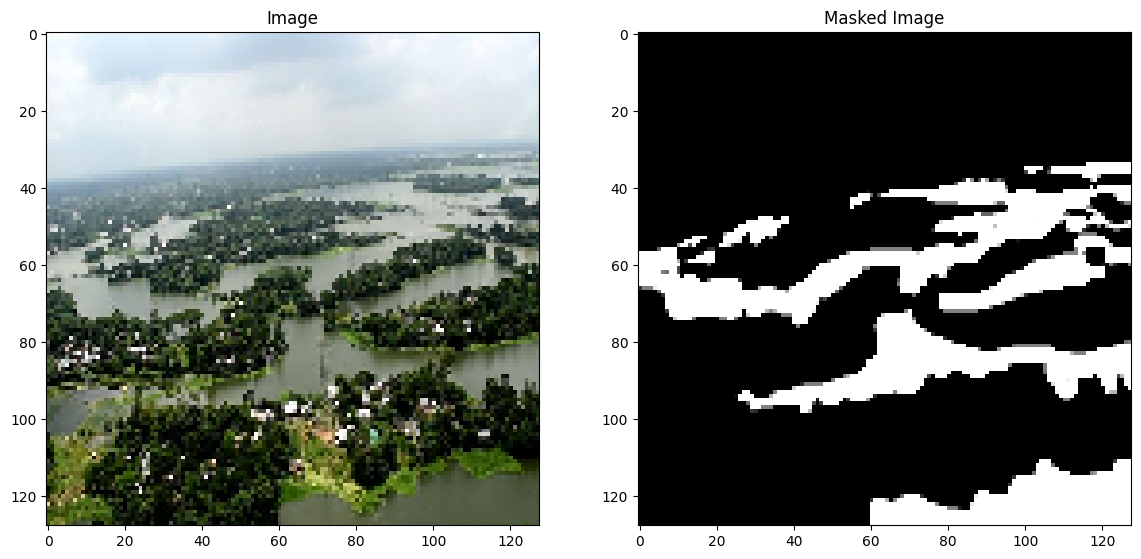

In [7]:
random_image_id = random.randint(0, len(train_generator) - 1)
sample_image, sample_mask = train_generator[random_image_id]

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(sample_image[0])  # Extract the first image from batch
plt.title("Image")

plt.subplot(122)
plt.imshow(sample_mask[0].squeeze(), cmap='gray')  # Extract and squeeze mask
plt.title("Masked Image")
plt.show()


In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(image_filenames, mask_filenames, test_size=0.2, random_state=42)
train_generator = DataGenerator(train_images, train_masks, image_folder, mask_folder, batch_size=1)
val_generator = DataGenerator(val_images, val_masks, image_folder, mask_folder, batch_size=1)

In [8]:
def swin_transformer_block(x, num_heads, key_dim, window_size, channels):
    x_norm = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x_norm, x_norm)
    attn_output = layers.Conv2D(channels, (1, 1), padding='same')(attn_output)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)
    mlp = tf.keras.Sequential([
        layers.Dense(4 * channels, activation='gelu'),
        layers.Dense(channels)
    ])(x)
    x = layers.Add()([x, mlp])
    return x

# Swin U-Net Encoder Block
def swin_unet_encoder(x, num_blocks, num_heads, key_dim, window_size, channels):
    x = layers.Conv2D(channels, (3, 3), padding='same', activation='relu')(x)
    for _ in range(num_blocks):
        x = swin_transformer_block(x, num_heads, key_dim, window_size, channels)
    return x

# Swin U-Net Decoder Block
def swin_unet_decoder(x, skip_connection, num_blocks, num_heads, key_dim, window_size, channels):
    x = layers.UpSampling2D((2, 2))(x)
    skip_connection = layers.Conv2D(channels, (1, 1), padding='same')(skip_connection)
    x = layers.Concatenate()([x, skip_connection])
    x = swin_unet_encoder(x, num_blocks, num_heads, key_dim, window_size, channels)
    return x

# Swin U-Net Model
def build_swin_unet(input_shape=(128,128, 3), num_classes=1):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)  # Reduced channels to 32
    skip1 = swin_unet_encoder(x, num_blocks=1, num_heads=2, key_dim=32, window_size=7, channels=32)
    x = layers.MaxPooling2D((2, 2))(skip1)
    
    skip2 = swin_unet_encoder(x, num_blocks=1, num_heads=4, key_dim=64, window_size=7, channels=64)
    x = layers.MaxPooling2D((2, 2))(skip2)
    
    bottleneck = swin_unet_encoder(x, num_blocks=2, num_heads=8, key_dim=128, window_size=7, channels=128)
    
    x = swin_unet_decoder(bottleneck, skip2, num_blocks=1, num_heads=4, key_dim=64, window_size=7, channels=64)
    x = swin_unet_decoder(x, skip1, num_blocks=1, num_heads=2, key_dim=32, window_size=7, channels=32)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model


In [9]:

from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall

mIoU = MeanIoU(num_classes=2)
precision = Precision()
recall = Recall()

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    return mIoU(y_true, y_pred)

def dice_coefficient(y_true, y_pred):
    smooth = 1.0  
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [10]:
input_shape = (128,128, 3)
model = build_swin_unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss=combined_loss,  
              metrics=["accuracy",dice_coefficient, f1_score, mean_iou, precision, recall])

In [11]:
model_history=model.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


231/231 ━━━━━━━━━━━━━━━━━━━━ 112s 340ms/step - accuracy: 0.5504 - dice_coefficient: 0.4624 - f1_score: 0.5040 - loss: 0.6127 - mean_iou: 0.2960 - precision: 0.4824 - recall: 0.6424 - val_accuracy: 0.7971 - val_dice_coefficient: 0.6973 - val_f1_score: 0.8031 - val_loss: 0.3668 - val_mean_iou: 0.2981 - val_precision: 0.7449 - val_recall: 0.8426
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 323ms/step - accuracy: 0.7910 - dice_coefficient: 0.6464 - f1_score: 0.7629 - loss: 0.4032 - mean_iou: 0.2991 - precision: 0.7285 - recall: 0.7798 - val_accuracy: 0.8111 - val_dice_coefficient: 0.7206 - val_f1_score: 0.8008 - val_loss: 0.3384 - val_mean_iou: 0.2977 - val_precision: 0.8176 - val_recall: 0.7538
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 324ms/step - accuracy: 0.8185 - dice_coefficient: 0.6580 - f1_score: 0.7464 - loss: 0.3768 - mean_iou: 0.2989 - precision: 0.7722 - recall: 0.7588 - val_accuracy: 0.8349 - val_dice_coefficient: 0.7277 - val_f1_score: 0.8139 - val_loss: 0.3215 - val_mean_io

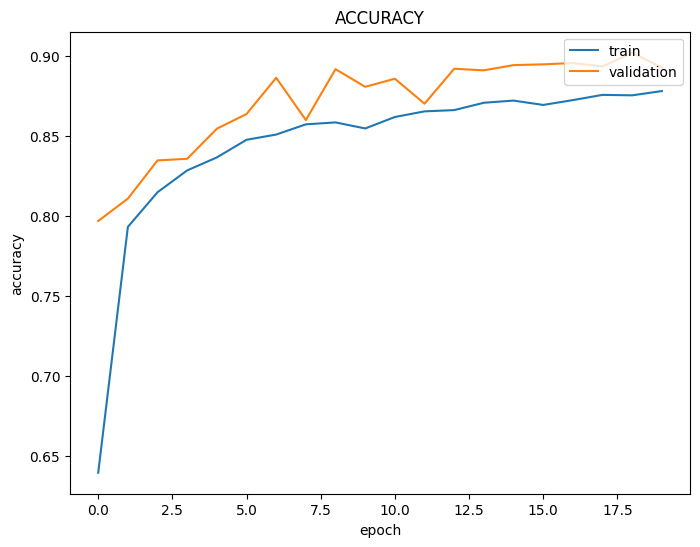

In [12]:
fig,ax11=plt.subplots(figsize=(8,6))
ax11.plot(model_history.history['accuracy'])
ax11.plot(model_history.history['val_accuracy'])
ax11.title.set_text('ACCURACY')
ax11.set_ylabel('accuracy')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper right')

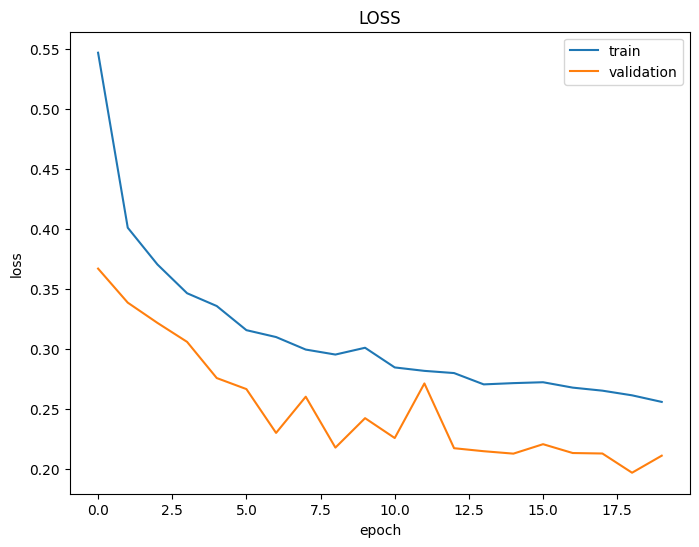

In [13]:
fig,ax12 = plt.subplots(figsize=(8,6))
ax12.plot(model_history.history['loss'])
ax12.plot(model_history.history['val_loss'])
ax12.title.set_text('LOSS')
ax12.set_ylabel('loss')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper right')

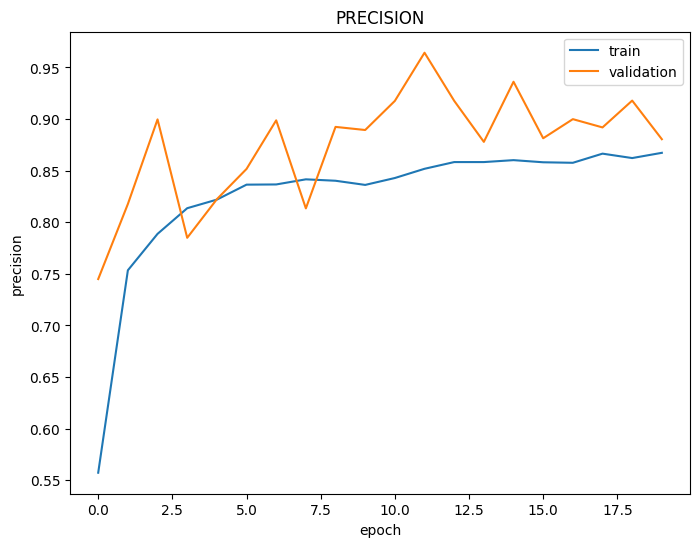

In [15]:
fig,ax13=plt.subplots(figsize=(8,6))
ax13.plot(model_history.history['precision'])
ax13.plot(model_history.history['val_precision'])
ax13.title.set_text('PRECISION')
ax13.set_ylabel('precision')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper right')

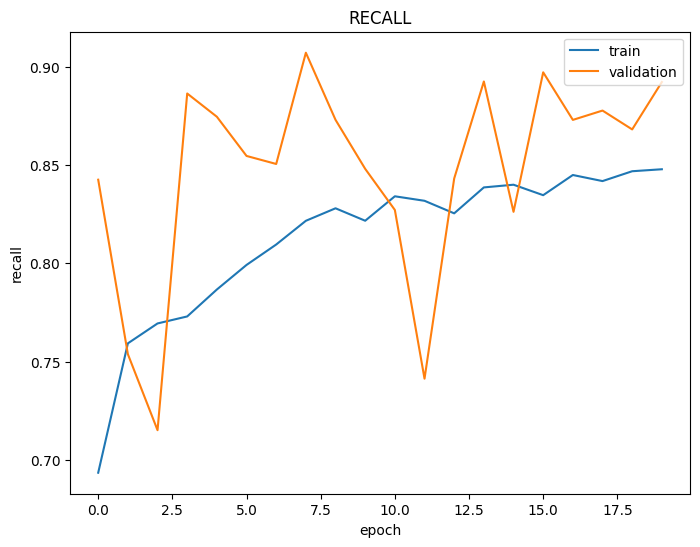

In [16]:
fig,ax14=plt.subplots(figsize=(8,6))
ax14.plot(model_history.history['recall'])
ax14.plot(model_history.history['val_recall'])
ax14.title.set_text('RECALL')
ax14.set_ylabel('recall')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper right')

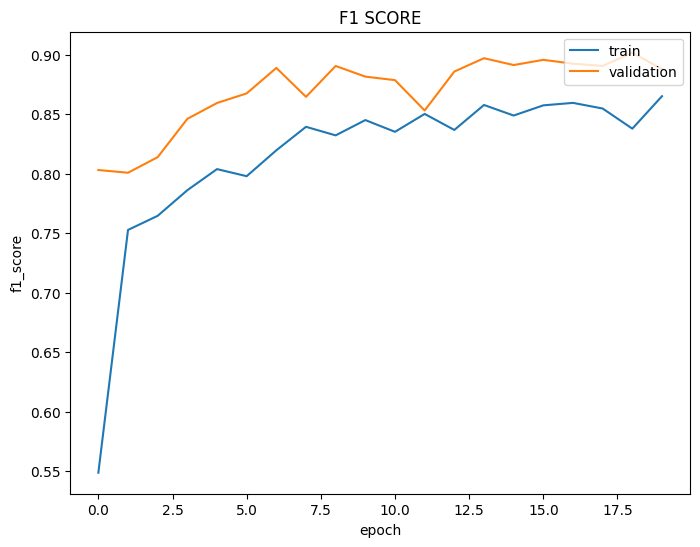

In [17]:
fig,ax15=plt.subplots(figsize=(8,6))
ax15.plot(model_history.history['f1_score'])
ax15.plot(model_history.history['val_f1_score'])
ax15.title.set_text('F1 SCORE')
ax15.set_ylabel('f1_score')
ax15.set_xlabel('epoch')
ax15.legend(['train', 'validation'], loc='upper right')

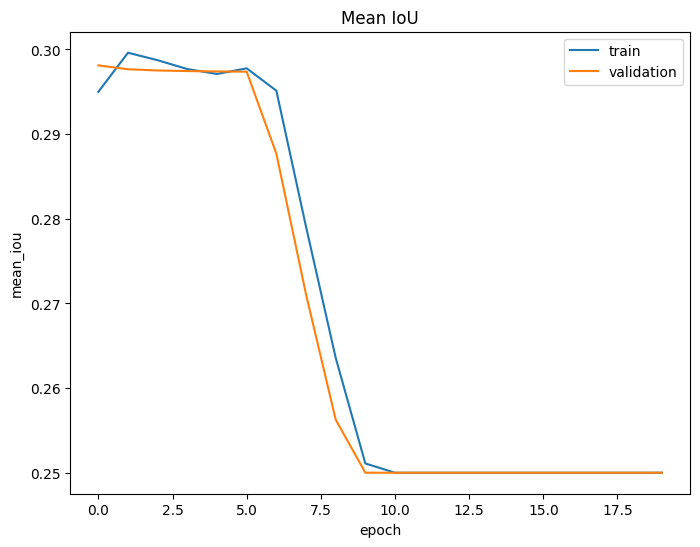

In [18]:
fig,ax16=plt.subplots(figsize=(8,6))
ax16.plot(model_history.history['mean_iou'])
ax16.plot(model_history.history['val_mean_iou'])
ax16.title.set_text('Mean IoU')
ax16.set_ylabel('mean_iou')
ax16.set_xlabel('epoch')
ax16.legend(['train', 'validation'], loc='upper right')

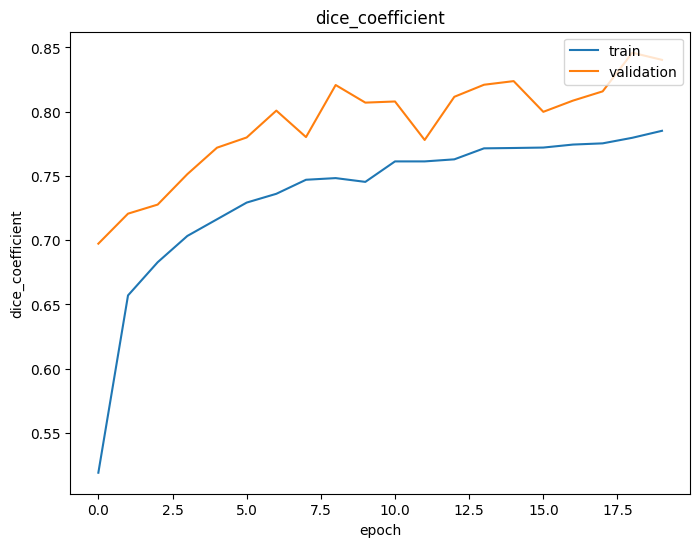

In [28]:
fig,ax17=plt.subplots(figsize=(8,6))
ax17.plot(model_history.history['dice_coefficient'])
ax17.plot(model_history.history['val_dice_coefficient'])
ax17.title.set_text('dice_coefficient')
ax17.set_ylabel('dice_coefficient')
ax17.set_xlabel('epoch')
ax17.legend(['train', 'validation'], loc='upper right')

In [19]:
pred_masks = model.predict(test_generator)
pred_masks = (pred_masks > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


In [21]:
loss,dice_coefficient, accuracy, f1_score, precision, recall,mean_iou = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"dice coefficient: {dice_coefficient:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1_score:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test MeanIoU: {mean_iou:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8917 - dice_coefficient: 0.8166 - f1_score: 0.8971 - loss: 0.2194 - mean_iou: 0.2500 - precision: 0.8791 - recall: 0.8903
Test Loss: 0.2391
dice coefficient: 0.8911
Test Accuracy: 0.7823
Test F1 Score: 0.8865
Test Precision: 0.2500
Test Recall: 0.8387
Test MeanIoU: 0.8894


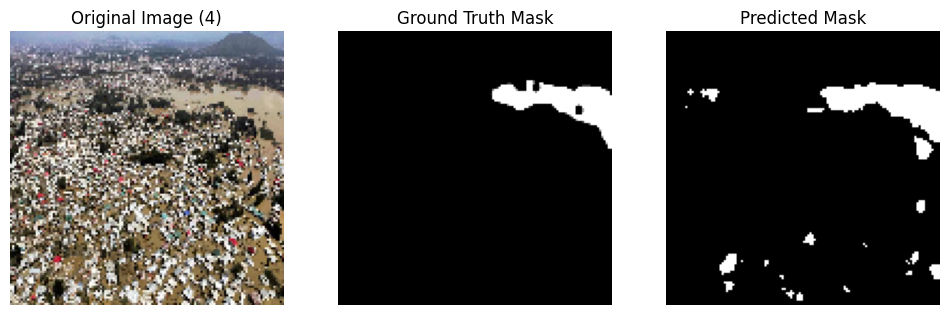

In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

def visualize_random_prediction(test_generator, pred_masks):
    # Select a random index from the test set
    idx = random.randint(0, len(test_generator) - 1)

    # Load a batch (assuming batch_size=1 for visualization)
    test_image, test_mask = test_generator[idx]  # Returns (image, mask)

    # Remove batch dimension
    test_image = test_image[0]  # Shape: (H, W, C)
    test_mask = test_mask[0].squeeze()  # Shape: (H, W)
    pred_mask = pred_masks[idx].squeeze()  # Ensure same shape

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title(f"Original Image ({idx})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

# Call the function
visualize_random_prediction(test_generator, pred_masks)
